TODO:
* experiment with narrower sampling of thetas / less trials / fixed presentation time
* analysis with train set / test set

In [1]:
%run experiment1.ipynb

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.0

numpy       : 1.26.4
MotionClouds: 20220927
manim       : 0.18.1
pandas      : 2.2.3
matplotlib  : 3.10.1
scipy       : 1.15.2

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local



## one logistic regression per session and per B_theta

Some inductive biases:

* the lapse rate is independent of `B_theta`
* the slope is parameterized for each `B_theta` and should decrease with it

In [2]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()
i_B_theta_trials = np.array(parameters['i_B_theta'])
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))*180/np.pi
# B_thetas, len(B_thetas)

In [3]:
# Best params:  {'batch_size': 11, 'etab1': 0.00809674756441486, 'etab2': 7.316329267880158e-05, 'learning_rate': 0.0034469777956771435, 'amsgrad': False, 'logit0': -3.0899047872305645, 'log_wt': -2.0385721992893386}
# Best params:  {'batch_size': 2, 'etab1': 0.021231015043172954, 'etab2': 2.2279395195458774e-05, 'learning_rate': 0.005893783241341296, 'amsgrad': True, 'logit0': -1.8636329895619623, 'log_wt': -1.9251590800881406}
# Best params: {'batch_size': 24, 'etab1': 0.00857849501562565, 'etab2': 1.0409114152035763e-05, 'learning_rate': 0.0745990192922949, 'amsgrad': True, 'logit0': -0.08218706436646056, 'log_wt': -0.518831161760116}
# Best value: 0.516 at 2025-03-18 08:42:49

# -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
# Best params: {'batch_size': 4, 'etab1': 0.019745022627345725, 'etab2': 9.919338385983741e-06, 'learning_rate': 0.01033905225562436, 'amsgrad': False, 'logit0': -0.5545586004712626, 'log_wt': 1.4969617623606375}
# Best value: 0.506 at 2025-03-18 10:12:37
# --------------------------------------------------
num_epochs = 2 ** 9 + 1
optimizer = 'adam'
learning_rate = 0.01
etab1, etab2 = 0.02, 1e-5
weight_decay = 0.001
batch_size = 24
amsgrad = True
logit0 = -.1
log_wt = -.5
theta0 = 0.
frozen_theta0 = True

In [4]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0=logit0, theta0=theta0, log_wt=log_wt, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        # self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.theta0 = torch.nn.Parameter(torch.tensor(theta0))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(torch.tensor(logit0))
        self.log_wt = torch.nn.Parameter(torch.tensor(log_wt * torch.ones(len(B_thetas))))

    def forward(self, theta, i_B_theta):
        p0 = self.logit0.sigmoid()
        output = p0 / 2. + (1. - p0) * ((theta-self.theta0)/self.log_wt[i_B_theta].exp()).sigmoid()
        return output
    
def fit_data(
    theta_trials,
    i_B_theta_trials,
    y,
    logit0=logit0, theta0=theta0, log_wt=log_wt, 
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, optimizer=optimizer, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2, weight_decay=weight_decay,
    verbose=False
):


    theta_trials, i_B_theta_trials, labels = torch.Tensor(theta_trials[:, None]), torch.Tensor(i_B_theta_trials[:, None]).long(), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(theta_trials, i_B_theta_trials, labels), batch_size=batch_size, shuffle=True
    )

    total_loss = torch.log(torch.tensor(2)) # criterion(outputs, labels_)
        
    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, theta0=theta0, frozen_theta0=frozen_theta0)
    logistic_model = logistic_model.to(device)
    logistic_model.train()

    optimizer_dict = dict(lr=learning_rate, weight_decay=weight_decay, betas=(1-etab1, 1-etab2), amsgrad=amsgrad)
    if optimizer=='adam': 
        optimizer = torch.optim.Adam(logistic_model.parameters(), **optimizer_dict)
    elif optimizer=='adamw': 
        optimizer = torch.optim.AdamW(logistic_model.parameters(), **optimizer_dict)    

    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for theta_, i_B_theta_, labels_ in loader:
            theta_, i_B_theta_, labels_ = theta_.to(device), i_B_theta_.to(device), labels_.to(device)

            # print(theta_, i_B_theta_)
            outputs_ = logistic_model(theta_, i_B_theta_)
            # print(outputs_, labels_)
            loss = criterion(outputs_, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.3e}")
            # print(f"Iteration: {epoch} - Evidence: {-np.mean(losses):.3e}")

    logistic_model.eval()
    outputs = logistic_model(theta_trials, i_B_theta_trials.long())
    loss = criterion(outputs, labels).item()
    # loss = - logistic_model.evidence(outputs, labels).item()
    return logistic_model, loss / total_loss


frozen_theta0=False
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_17646/40571746.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_wt = torch.nn.Parameter(torch.tensor(log_wt * torch.ones(len(B_thetas))))


for apagrpwbxf, Loss = 4.862e-01 - theta0 = -1.42°, p0 = 1.29e-01, slope = 9.42e+00


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_17646/40571746.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_wt = torch.nn.Parameter(torch.tensor(log_wt * torch.ones(len(B_thetas))))


for w87npww874, Loss = 4.652e-01 - theta0 = -1.74°, p0 = 1.85e-01, slope = 7.20e+00
for 64dtdq27os, Loss = 6.591e-01 - theta0 = 1.49°, p0 = 1.52e-01, slope = 1.42e+01
for w2oz9j2a3v, Loss = 6.288e-01 - theta0 = 2.98°, p0 = 1.49e-01, slope = 4.97e-01
for wsumnmxd8c, Loss = 3.905e-01 - theta0 = -0.17°, p0 = 5.78e-02, slope = 4.53e+01
for rtumbda4hz, Loss = 6.327e-01 - theta0 = 1.31°, p0 = 1.83e-01, slope = 2.07e-01
for ybaxemnk16, Loss = 3.863e-01 - theta0 = 0.43°, p0 = 7.11e-03, slope = 7.93e+00
for 6l605rv4nn, Loss = 7.063e-01 - theta0 = 0.31°, p0 = 2.78e-01, slope = 2.83e+01
for t7vs2ac7eg, Loss = 3.757e-01 - theta0 = 0.47°, p0 = 3.14e-03, slope = 1.74e+01
for 0ck7pzlpvw, Loss = 4.535e-01 - theta0 = -2.28°, p0 = 3.02e-02, slope = 1.36e+01
for 64jgewoyyw, Loss = 4.612e-01 - theta0 = 1.44°, p0 = 2.96e-02, slope = 9.70e+00
for 39dqyx1uj0, Loss = 4.422e-01 - theta0 = -1.34°, p0 = 7.29e-02, slope = 6.87e+00
for wtlob6kr2e, Loss = 5.846e-01 - theta0 = -0.36°, p0 = 8.74e-02, slope = 1.17e+01

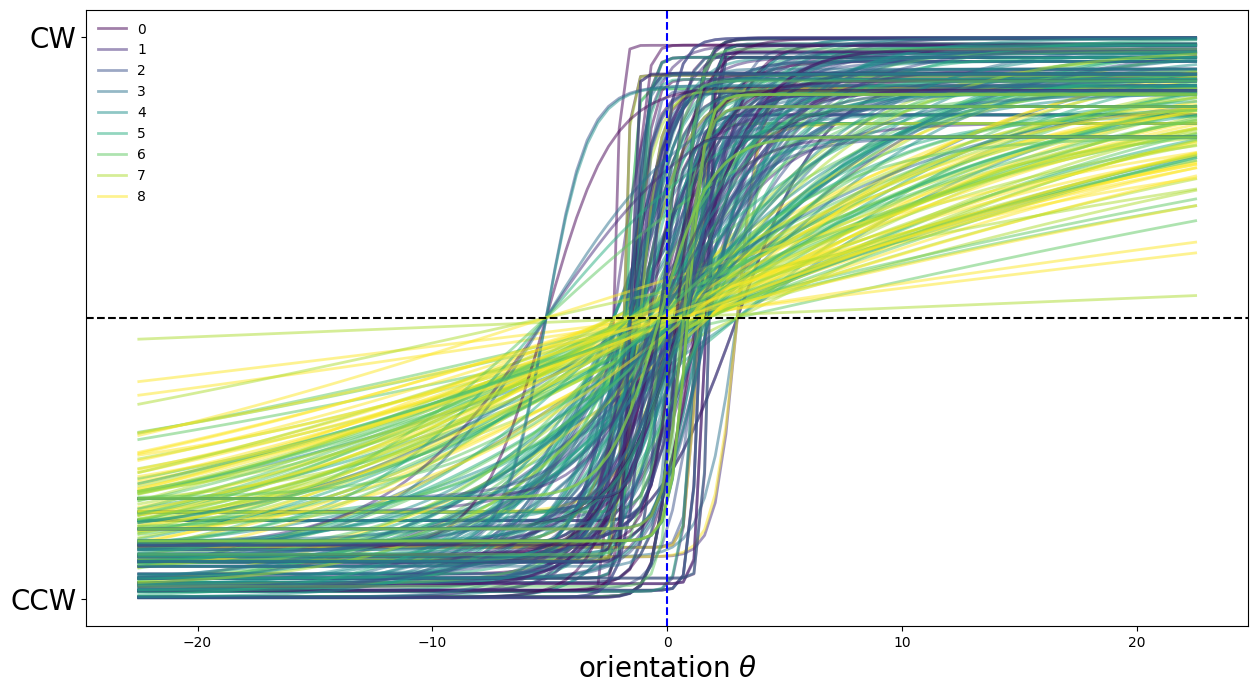

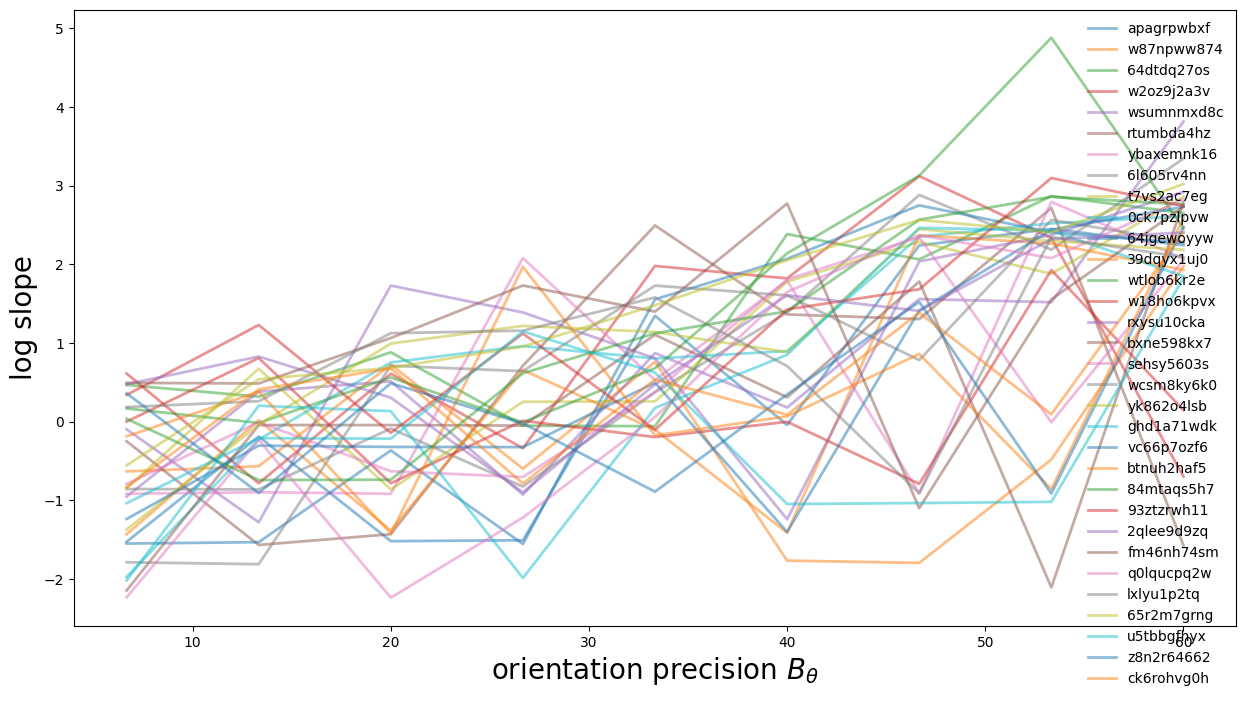

frozen_theta0=True
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_17646/40571746.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_wt = torch.nn.Parameter(torch.tensor(log_wt * torch.ones(len(B_thetas))))


for apagrpwbxf, Loss = 5.074e-01 - theta0 = 0.00°, p0 = 1.34e-01, slope = 8.31e+00
for w87npww874, Loss = 4.948e-01 - theta0 = 0.00°, p0 = 1.77e-01, slope = 7.29e+00
for 64dtdq27os, Loss = 6.638e-01 - theta0 = 0.00°, p0 = 1.64e-01, slope = 1.31e+01
for w2oz9j2a3v, Loss = 6.722e-01 - theta0 = 0.00°, p0 = 1.57e-01, slope = 2.16e+00
for wsumnmxd8c, Loss = 3.884e-01 - theta0 = 0.00°, p0 = 6.01e-02, slope = 2.73e+01
for rtumbda4hz, Loss = 5.919e-01 - theta0 = 0.00°, p0 = 1.80e-02, slope = 8.50e+00
for ybaxemnk16, Loss = 3.880e-01 - theta0 = 0.00°, p0 = 6.84e-03, slope = 7.78e+00
for 6l605rv4nn, Loss = 7.063e-01 - theta0 = 0.00°, p0 = 2.70e-01, slope = 3.23e+01
for t7vs2ac7eg, Loss = 3.813e-01 - theta0 = 0.00°, p0 = 2.40e-03, slope = 1.68e+01
for 0ck7pzlpvw, Loss = 4.546e-01 - theta0 = 0.00°, p0 = 8.95e-04, slope = 1.35e+01
for 64jgewoyyw, Loss = 4.642e-01 - theta0 = 0.00°, p0 = 1.37e-02, slope = 1.56e+01
for 39dqyx1uj0, Loss = 4.492e-01 - theta0 = 0.00°, p0 = 5.46e-02, slope = 9.15e+00
for 

In [ ]:
# for the plot
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(B_thetas) - 1)

for frozen_theta0 in [False, True]:

    print(f'{frozen_theta0=}')
    print(50*'.-*')
    
    fig, ax = plt.subplots(figsize=(15, 8))
    fig2, ax2 = plt.subplots(figsize=(15, 8))

    for session in responses.keys():    
        y = responses[session]

        logistic_model, loss = fit_data(theta_trials, i_B_theta_trials, y, frozen_theta0=frozen_theta0, verbose=False)
        print(f"for {session}, Loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.2f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.2e}, slope = {torch.exp(logistic_model.log_wt[-1]).item():.2e}")

        for i_B_theta in range(len(B_thetas)):
            y_values = logistic_model(torch.Tensor(x_values), (i_B_theta*torch.ones_like(torch.Tensor(x_values)).long())).detach().numpy()
            ax.plot(x_values, y_values, color=cmap(norm(i_B_theta)), alpha=0.5, lw=2, label=f'{i_B_theta}' if session==list(responses.keys())[0] else None)
        ax2.plot(B_thetas, logistic_model.log_wt.detach().numpy(), alpha=0.5, lw=2, label=session)
        # print(logistic_model.log_wt.detach().numpy())

    ax.set_xlabel(r"orientation $\theta$", fontsize=20)
    ax.axhline(.5, color='k', linestyle='--')
    ax.axvline(0., color='b', linestyle='--')
    ax.set_yticks([0.0, 1.0])
    ax.set_yticklabels(["CCW", "CW"], fontsize=20)
    ax.legend(fontsize=10, frameon=False, scatterpoints=6);


    ax2.set_xlabel(r"orientation precision $B_\theta$", fontsize=20)
    ax2.set_ylabel(r"log slope", fontsize=20)
    ax2.legend(fontsize=10, frameon=False, scatterpoints=6);

    
    plt.show();


### optimize learning parameters with optuna

In [ ]:
logistic_model, loss = fit_data(theta_trials, i_B_theta_trials, y, verbose=True)

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = 'i_B_theta'
path_save_optuna = os.path.join('/tmp', f'optuna_{study_name}.sqlite3') # global name
# %rm {path_save_optuna}

In [ ]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 64, log=True, step=1)
    vars['optimizer'] = trial.suggest_categorical('optimizer', ['adamw', 'adam']) # 'adagrad', 'sparseadam', 'rmsprop', 'adadelta', 'sgd',

    max_threshold = .999
    scale = 4
    scale = 2
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    # initialization
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    for session in responses.keys():    
        y = responses[session]
        _, loss_ = fit_data(theta_trials, i_B_theta_trials, y, **vars)
        loss += loss_
    return loss/len(filenames_valid)

print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name=study_name)
study.optimize(objective, n_trials=max((200-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

In [ ]:
print(50*'-.')
print(f"Best params: {study.best_params}")
print(f"Best value: {study.best_value:.3f} at {now.strftime("%Y-%m-%d %H:%M:%S")}")
print(50*'-')